In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import gen_batches
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LinearRegression

import time

import pickle
import joblib
import os

import re

# MNIST

In [2]:
# Download data
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
# Save data in file 'Xy.npz'
np.savez('Xy', X=X, y=y)

/Users/amaros/miniconda3/envs/physics/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


# Restricted Boltzmann Machine

In [3]:
class RBM():
    """
    Restricted Boltzmann machine

    Reference: 
        Hinton, G. E., Osindero, S. and Teh, Y. 
        *A fast learning algorithm for deep belief nets*. 
        Neural Computation 18, pp 1527-1554.
        pdf: https://www.cs.toronto.edu/~hinton/absps/fastnc.pdf
    """
    def __init__(self, Nv, Nh, T, L, gamma):
        self.Nv = Nv            # number of visible units (28^2)
        self.Nh = Nh            # number of hidden units (30)
        self.gamma = gamma      # learning rate (0.1)
        self.T = T              # number of iterations
        self.L = L              # batch data size
        self.errors = []        # to extract errors values for one iteration

        # random number generator
        rng = np.random.default_rng(50419) # arbitrary seed

        # initial weights
        self.W = rng.normal(0, 0.01, size=(Nv, Nh))

        # initial biases
        self.a = rng.normal(0, 1, size=Nv)
        self.b = rng.normal(0, 1, size=Nh)


    def sigmoid(self, x):
        """
        Sigmoid function
        """
        return 1 / (1 + np.exp(-x))
        
    def optimizeRBM(self, X):
        """
        Training the RBM using the contrasted divergence of Hinton 

        Parameters
        ----------
        X: training data

        Returns
        -------
        self: the trained RBM with the optimal set of parameters
        """
        rng = np.random.default_rng(12) # uniform
        for t in range(self.T):
            error_t = 0
            batches = list(gen_batches(X.shape[0], self.L))
            # constrasted divergence
            for batch in batches:
                # Positive sweep (data average)
                v = X[batch.start:batch.stop] # dim = (L, Nv)
                # Lv = len(v)
                prob_hPos = self.sigmoid(np.dot(v, self.W) + self.b)  # p(h=1|v) dim = (L,Nh)
                hvPos = np.dot(v.T, prob_hPos) # scalar product <v prob_hPos> dim = (Nv,Nh)
                
                # Negative sweep (model average)
                vmean = self.sigmoid(np.dot(prob_hPos, self.W.T) + self.a)  # p(v=1|h) dim = (L,Nv)
                prob_hNeg = self.sigmoid(np.dot(vmean, self.W) + self.b)  # p(h=1|vmean) dim = (L, Nh)

                hvNeg = np.dot(vmean.T, prob_hNeg) # scalar product <vmean prob_hNeg> dim = (Nv, Nh)
                error = np.sum((v-vmean)**2)/self.L
                
                # update parameters and error
                self.W += self.gamma*(hvPos - hvNeg)/self.L
                self.a += self.gamma*np.mean(v - vmean)
                self.b += self.gamma*np.mean(prob_hPos - prob_hNeg)
                error_t += error

            # Error
            error_t = error_t/len(batches)
            self.errors.append(error_t)
            print(f"iteration: {1+t}/{self.T} \t{'error:'} {error_t}")
    
    def identify_X(self, X):
        """
        Use the trained RBM to reconstruct test data

        Parameters
        ----------
        X: test data

        Returns
        -------
        self: visible state with the identified data
        """
        rng = np.random.default_rng(42)  # initialize a random number generator with a fixed seed
        v = X  # initialize visible with the selected test data

        prob_h = self.sigmoid(np.dot(v, self.W) + self.b)  # p(h=1|v)
        state_h = (prob_h > rng.random(prob_h.shape)).astype(int)

    
        # Reconstruct visible state from hidden state
        prob_v = self.sigmoid(np.dot(state_h, self.W.T) + self.a)  # p(v=1|h)
        state_v = (prob_v > rng.random(prob_v.shape)).astype(int)
    
        return state_v

# Data overview

In [4]:
# MNIST data base of hand written digits

file_Xy = np.load('Xy.npz', allow_pickle=True)
X_dat = file_Xy['X'] # (70000, 784) images 28x28
y_dat = file_Xy['y'] # (70000) labels

In [5]:
print(len(X_dat[0]))
X_dat[0]

784


array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

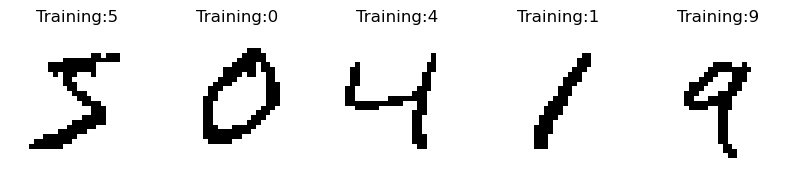

In [6]:
def X_image(N_img, X, y):
    _, axes = plt.subplots(nrows=1, ncols=N_img, figsize=(10, 3))
    for ax, image, label in zip(axes, X[:5].reshape((N_img, 28, 28)), y[:N_img]):
        ax.set_axis_off()
        ax.imshow(1 - image, cmap='gray')
        ax.set_title("Training:"+label)

# transform data to binary 

X = X_dat/255 # normalize to (0,1)
X = X > 0.5
X_image(5, X, y_dat)

In [7]:
# Train test split

X_train, X_test, Y_train, Y_test = train_test_split(X, y_dat, test_size=10000, random_state=42, stratify=y_dat)

In [8]:
list(gen_batches(X_train.shape[0], 16))

[slice(0, 16, None),
 slice(16, 32, None),
 slice(32, 48, None),
 slice(48, 64, None),
 slice(64, 80, None),
 slice(80, 96, None),
 slice(96, 112, None),
 slice(112, 128, None),
 slice(128, 144, None),
 slice(144, 160, None),
 slice(160, 176, None),
 slice(176, 192, None),
 slice(192, 208, None),
 slice(208, 224, None),
 slice(224, 240, None),
 slice(240, 256, None),
 slice(256, 272, None),
 slice(272, 288, None),
 slice(288, 304, None),
 slice(304, 320, None),
 slice(320, 336, None),
 slice(336, 352, None),
 slice(352, 368, None),
 slice(368, 384, None),
 slice(384, 400, None),
 slice(400, 416, None),
 slice(416, 432, None),
 slice(432, 448, None),
 slice(448, 464, None),
 slice(464, 480, None),
 slice(480, 496, None),
 slice(496, 512, None),
 slice(512, 528, None),
 slice(528, 544, None),
 slice(544, 560, None),
 slice(560, 576, None),
 slice(576, 592, None),
 slice(592, 608, None),
 slice(608, 624, None),
 slice(624, 640, None),
 slice(640, 656, None),
 slice(656, 672, None),
 slice

In [9]:
batch = list(gen_batches(X_train.shape[0], 16))[0]

X_train[batch.start:batch.stop]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

# Training the model

In [10]:
rbm = RBM(Nv=X_train.shape[1], Nh=30, T=40, L=16, gamma=0.1)

# Start timer
start_time = time.time()
rbm.optimizeRBM(X_train)
end_time = time.time()
# End timer

# Calculate and display the runtime
runtime = end_time - start_time
print(f"Training completed in {runtime:.2f} seconds.")

iteration: 1/40 	error: 39.80337990177484
iteration: 2/40 	error: 36.346482532221444
iteration: 3/40 	error: 36.69460422054453
iteration: 4/40 	error: 36.92289887440297
iteration: 5/40 	error: 36.95601910780834
iteration: 6/40 	error: 37.05351287353562
iteration: 7/40 	error: 37.14367584705713
iteration: 8/40 	error: 37.212029700933094
iteration: 9/40 	error: 37.22533390143719
iteration: 10/40 	error: 37.18530038519818
iteration: 11/40 	error: 37.137244526011145
iteration: 12/40 	error: 36.962690413840896
iteration: 13/40 	error: 36.77003238968892
iteration: 14/40 	error: 36.630853647404955
iteration: 15/40 	error: 36.54089426267475
iteration: 16/40 	error: 36.48017413676373
iteration: 17/40 	error: 36.422722059920204
iteration: 18/40 	error: 36.29584119710591
iteration: 19/40 	error: 36.175688813608275
iteration: 20/40 	error: 36.11260380424171
iteration: 21/40 	error: 36.0651619157212
iteration: 22/40 	error: 36.02708114059121
iteration: 23/40 	error: 35.9831720341877
iteration: 24/4

In [11]:
# from the test set get images with labels {0, 1, ..., 9)

test_labels = [np.where(Y_test == str(i))[0][0] for i in range(10)] # labels indices
test_images = X_test[test_labels] # 10 images with the digits

In [12]:
# RBM reconstruction of the test images

generated = rbm.identify_X(test_images) 

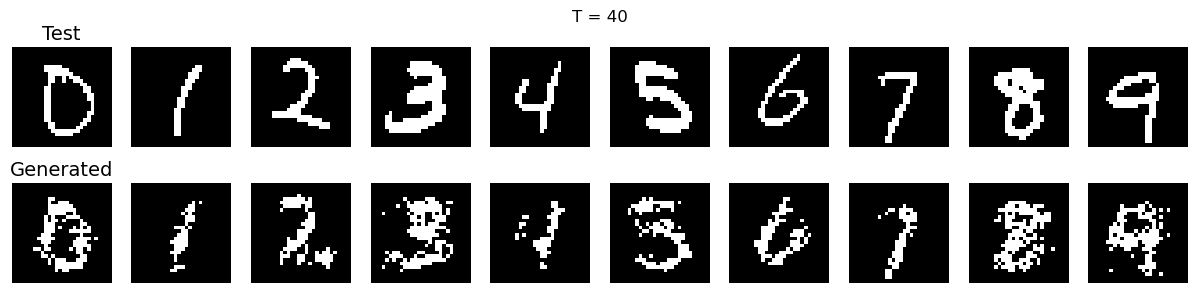

In [13]:
# Plot the original and reconstructed images

fig, ax = plt.subplots(nrows=2, ncols=10, sharey=True, figsize=(12, 3))
for c in range(10):
    # Original test images
    ax[0, c].imshow(test_images[c].reshape(28, 28), cmap='gray')  # Reshape to 28x28 for MNIST
    ax[0, c].set_axis_off()

    # Reconstructed images
    ax[1, c].imshow(generated[c].reshape(28, 28), cmap='gray')
    ax[1, c].set_axis_off()

ax[0, 0].set_title("Test", fontsize=14)
ax[1, 0].set_title("Generated", fontsize=14)


fig.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.91, wspace=0.2, hspace=0.02)
plt.suptitle(f"T = {rbm.T}")
plt.show()

In [15]:
# Test multiple values for T

runtime_list = []
generated_list = []
errors_list = []

for n_iter in np.arange(10,110,10):
    rbm = RBM(Nv=X_train.shape[1], Nh=30, T=n_iter, L=16, gamma=0.1)

    # Start timer
    start_time = time.time()
    rbm.optimizeRBM(X_train)
    end_time = time.time()
    # End timer
    
    # Calculate and display the runtime
    runtime = end_time - start_time
    print(f"Training completed in {runtime:.2f} seconds.")

    # RBM reconstruction of the test images
    generated = rbm.identify_X(test_images)

    runtime_list.append(runtime)
    generated_list.append(generated)
    errors_list.append(rbm.errors)

# Save as dictionary with pickle
tp_rbm = {'runtime':runtime_list,
          'generated':generated_list,
          'errors':errors_list}

try:
    with open('models/tp_rbm.pkl', 'wb') as f:
        pickle.dump(tp_rbm, f)
    print("Pickle file saved successfully.")
except Exception as e:
    print(f"Error saving pickle file: {e}")

iteration: 1/10 	error: 39.80337990177484
iteration: 2/10 	error: 36.346482532221444
iteration: 3/10 	error: 36.69460422054453
iteration: 4/10 	error: 36.92289887440297
iteration: 5/10 	error: 36.95601910780834
iteration: 6/10 	error: 37.05351287353562
iteration: 7/10 	error: 37.14367584705713
iteration: 8/10 	error: 37.212029700933094
iteration: 9/10 	error: 37.22533390143719
iteration: 10/10 	error: 37.18530038519818
Training completed in 30.44 seconds.
iteration: 1/20 	error: 39.80337990177484
iteration: 2/20 	error: 36.346482532221444
iteration: 3/20 	error: 36.69460422054453
iteration: 4/20 	error: 36.92289887440297
iteration: 5/20 	error: 36.95601910780834
iteration: 6/20 	error: 37.05351287353562
iteration: 7/20 	error: 37.14367584705713
iteration: 8/20 	error: 37.212029700933094
iteration: 9/20 	error: 37.22533390143719
iteration: 10/20 	error: 37.18530038519818
iteration: 11/20 	error: 37.137244526011145
iteration: 12/20 	error: 36.962690413840896
iteration: 13/20 	error: 36.7

In [16]:
# Read in pickle file

with open('models/tp_rbm.pkl', 'rb') as f:
    tp_rbm = pickle.load(f)

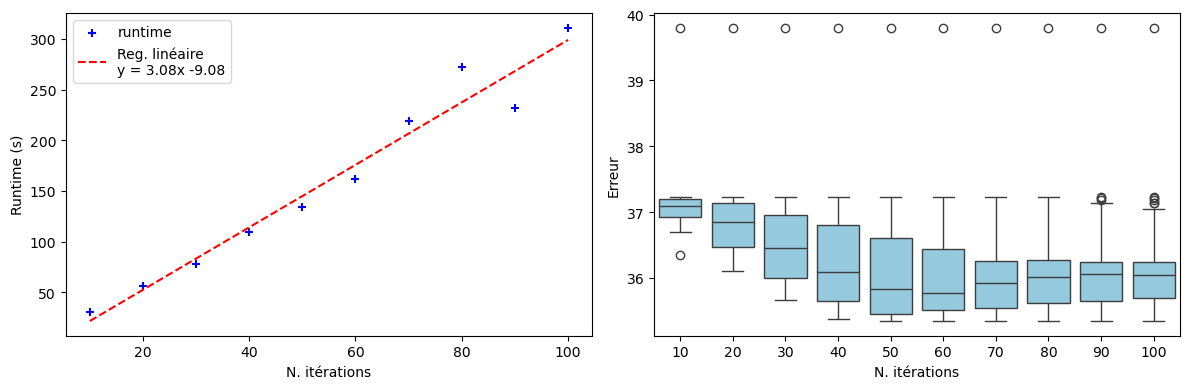

In [17]:
plt.figure(figsize=(12, 4))

# Perform linear regression
y_values = tp_rbm['runtime'].copy()
x_values = np.array([i for i in np.arange(10,110,10)]).reshape(-1, 1)  # Reshape for sklearn
model = LinearRegression()
model.fit(x_values, y_values)
y_pred = model.predict(x_values)

# Fig 1 : Runtime vs N. iterations
plt.subplot(121)
plt.scatter(np.arange(10, 110, 10), tp_rbm['runtime'], marker='+', color='blue', label='runtime')
plt.plot(x_values, y_pred, '--', color='red', label=f"Reg. linéaire\ny = {round(model.coef_[0],2)}x {round(model.intercept_, 2)}")
plt.xlabel("N. itérations")
plt.ylabel("Runtime (s)")
plt.legend()
# plt.title("Runtime vs N. iterations")

# Fig 2 : Errors boxplot
plt.subplot(122)
sns.boxplot(data=tp_rbm['errors'], color='skyblue')
plt.xlabel("N. itérations")
plt.xticks(ticks=np.arange(10), labels=[str(i) for i in np.arange(10, 110, 10)])
plt.ylabel("Erreur")
# plt.title("Error Distribution")

plt.tight_layout()

plt.savefig(f"figures/runtime_error_n_iter.png", dpi=300)

plt.show()

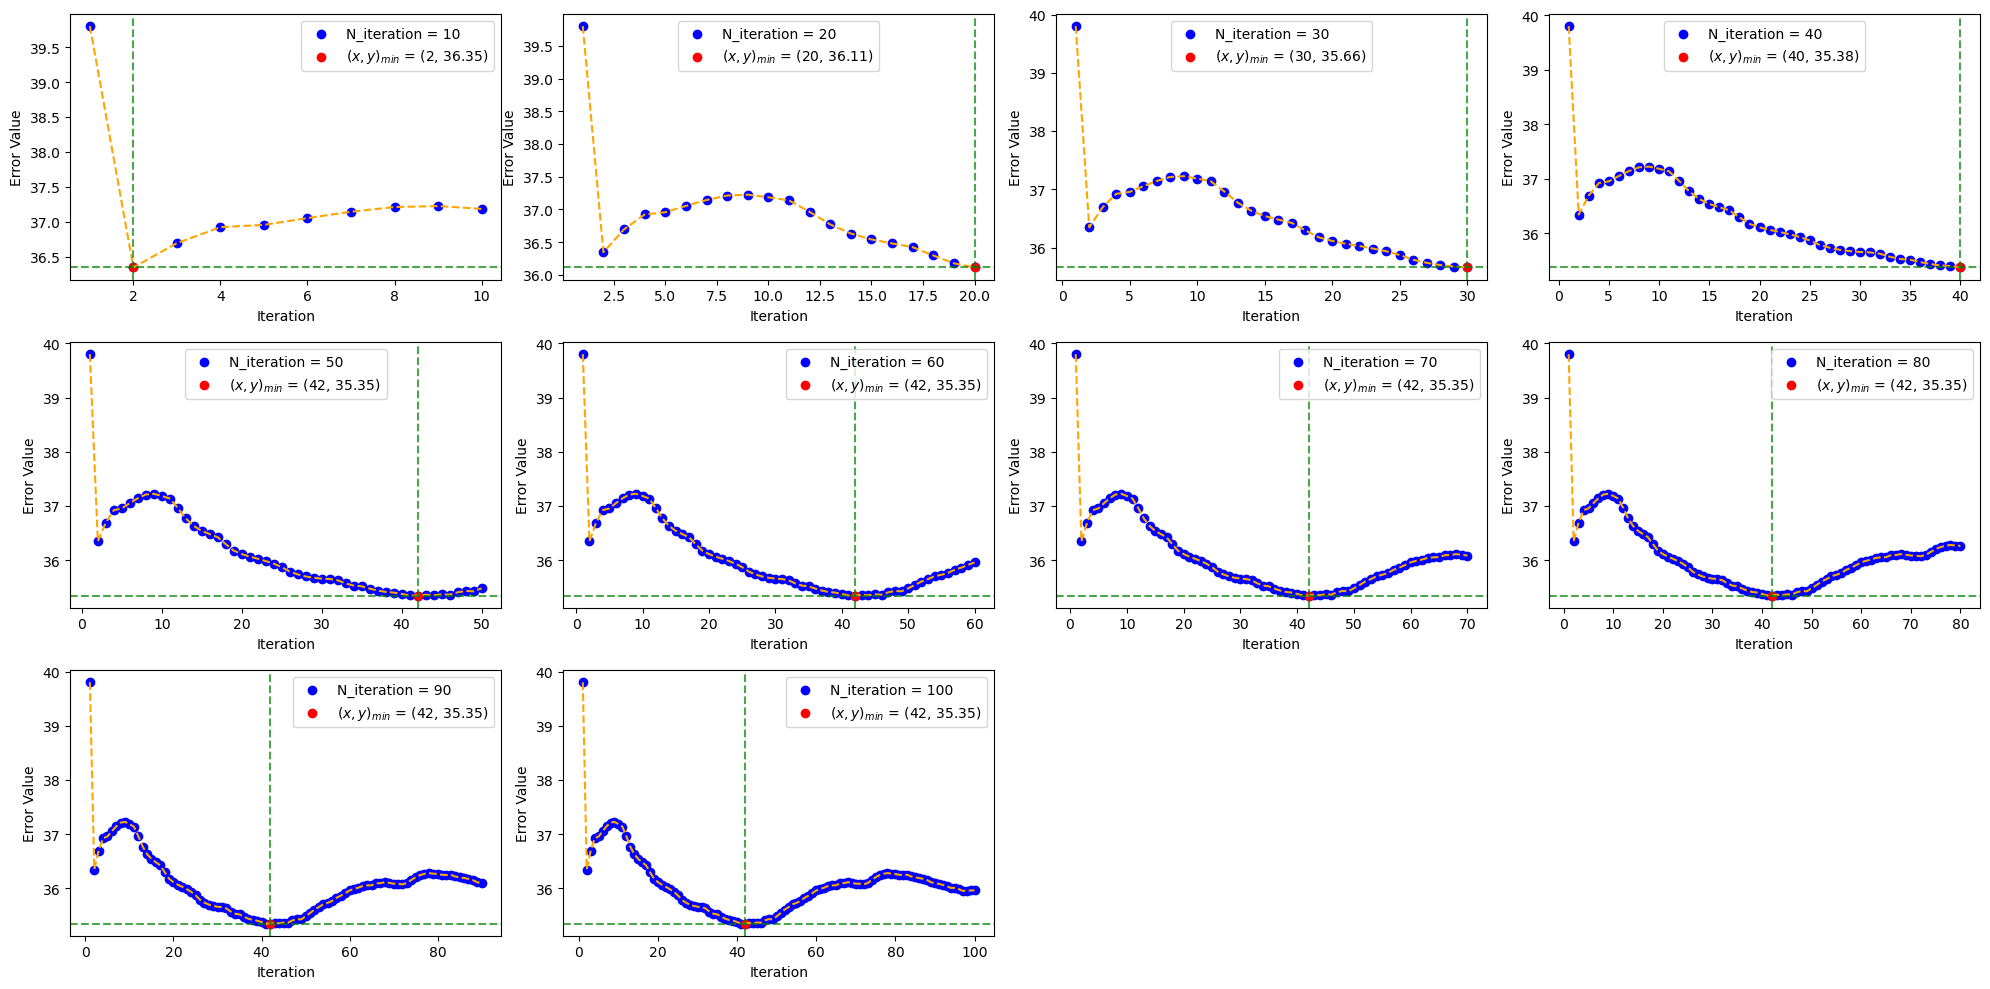

In [18]:
fig, axes = plt.subplots(3,4, figsize=(20, 10))

axes = axes.flatten()

for idx, (j, ax) in enumerate(zip(tp_rbm['errors'], axes)):

    # Generate x-axis values for the current array
    iterations = np.arange(1, len(j) + 1)
    
    # Plot the data
    ax.scatter(iterations, j, color='blue', label=f"N_iteration = {(idx + 1) * 10}")
    ax.plot(iterations, j, linestyle='--', color='orange')
    
    # Minimum error value and its corresponding iteration
    min_error = min(j)
    min_iteration = iterations[j.index(min_error)]
    
    # Add vertical and horizontal dashed lines at the minimum
    ax.axhline(y=min_error, linestyle='--', color='green', alpha=0.7)
    ax.axvline(x=min_iteration, linestyle='--', color='green', alpha=0.7)
    ax.scatter(min_iteration, min_error, color='red', label=f"$(x, y)_{{min}}$ = ({min_iteration}, {min_error:.2f})")

    # Set title and labels
    ax.set_ylabel('Error Value')
    ax.set_xlabel('Iteration')
    ax.legend()

for idx in range(len(tp_rbm['errors']), len(axes)):
    axes[idx].axis('off')

plt.savefig(f"figures/error_all.png", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

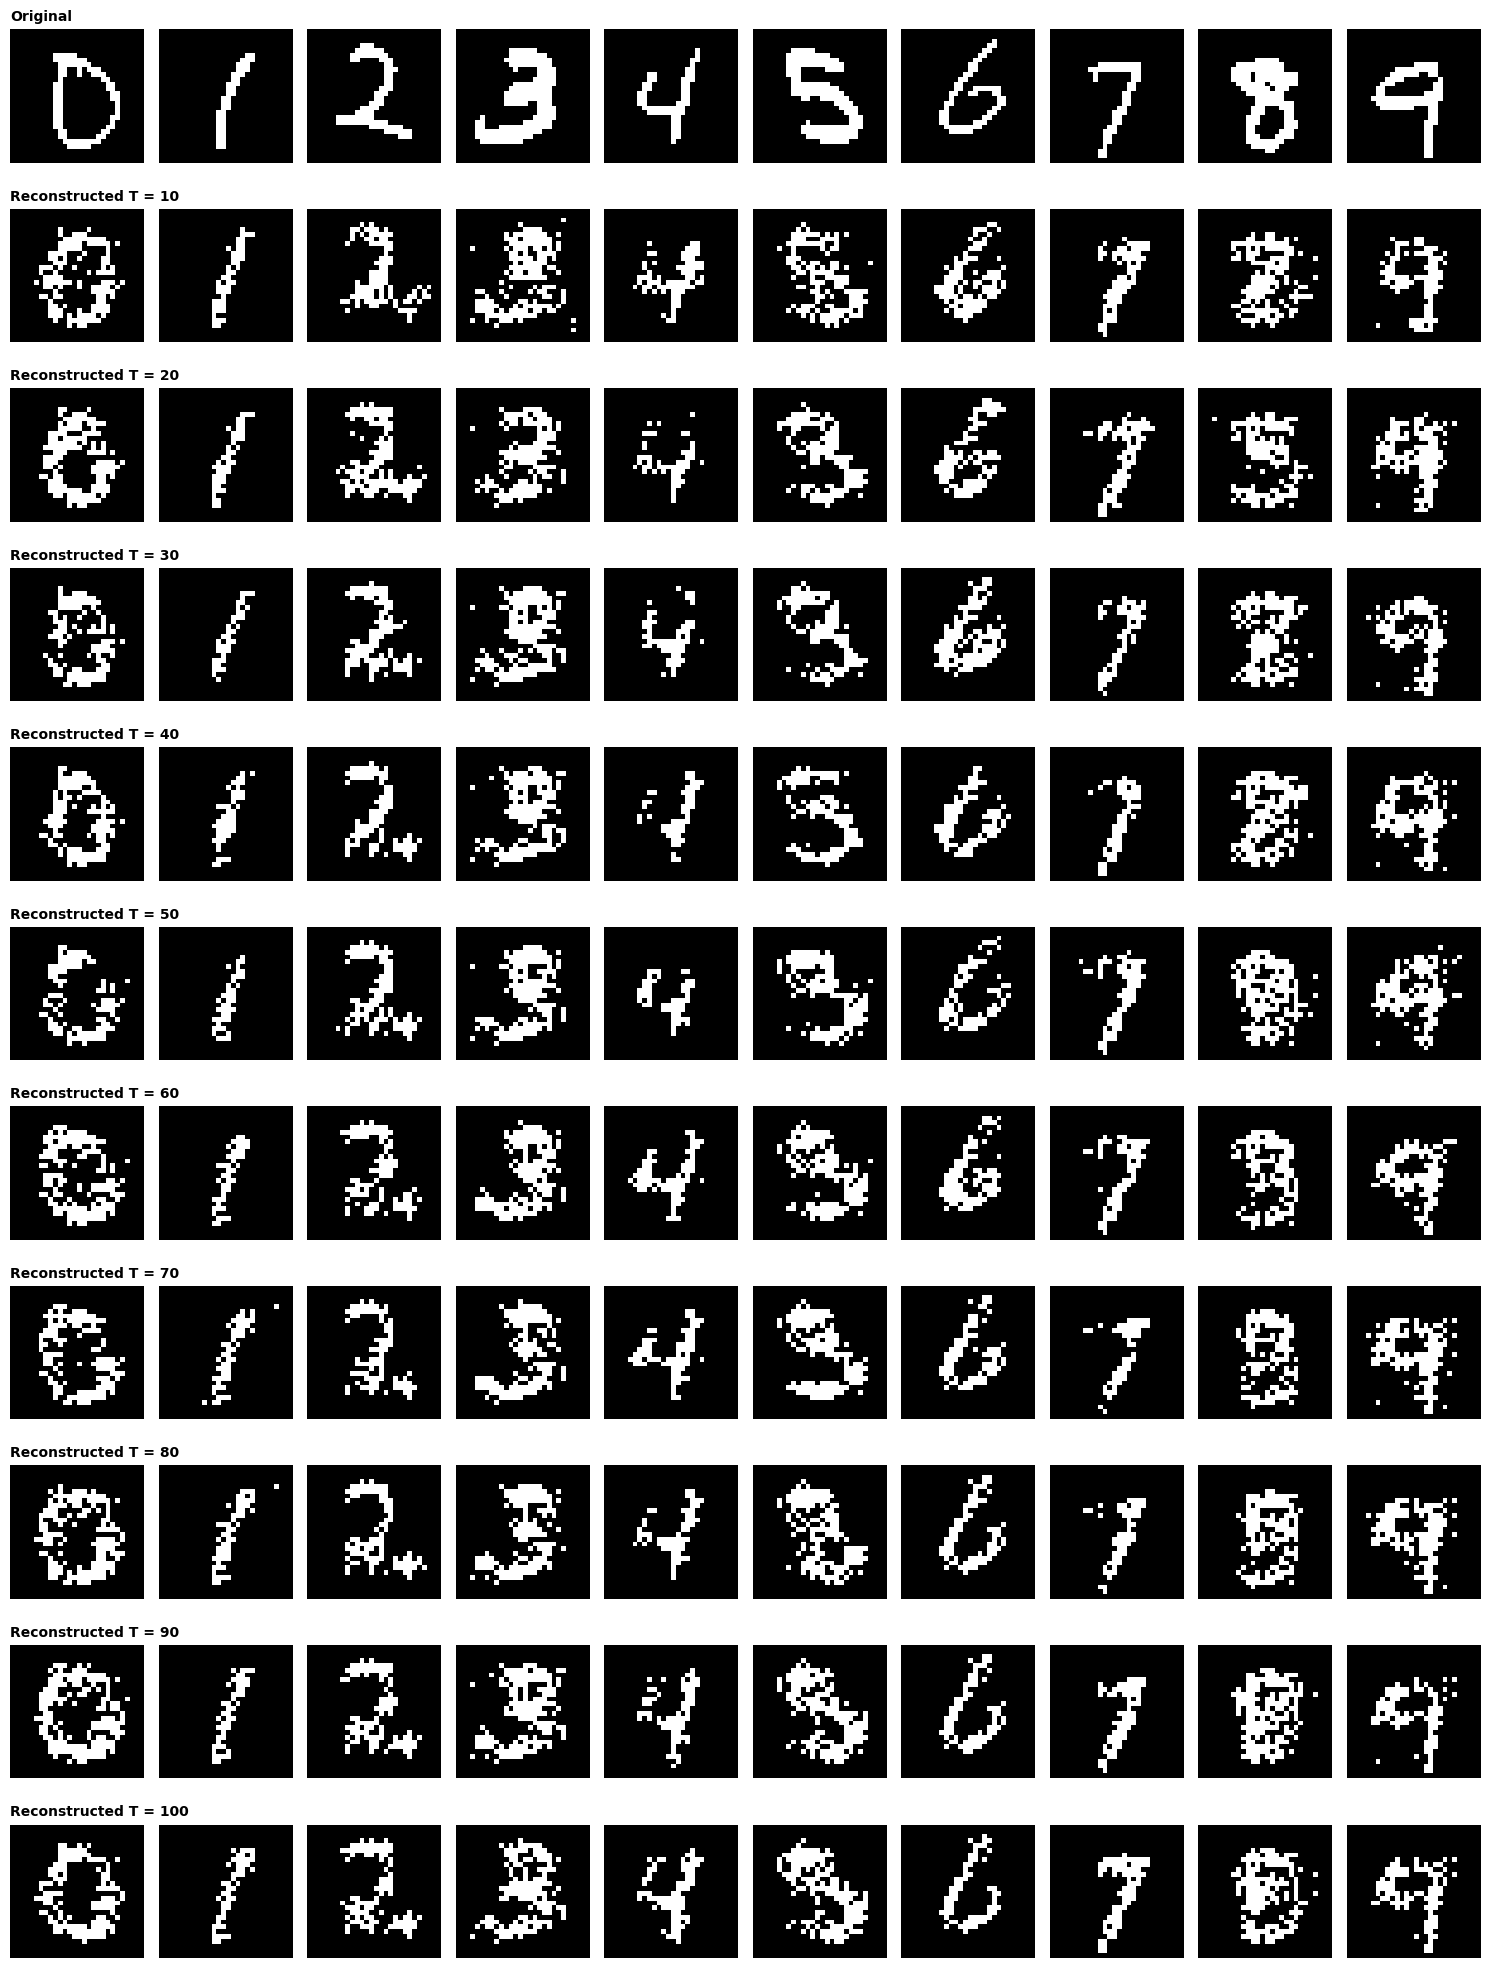

In [19]:
fig, ax = plt.subplots(nrows=11, ncols=10, sharey=True, figsize=(15, 20))

# Original test images (row 0)
for c in range(10):
    ax[0, c].imshow(test_images[c].reshape(28, 28), cmap='gray')  # Reshape to 28x28 for MNIST
    ax[0, c].set_axis_off()

ax[0, 0].set_title("Original", fontsize=10, fontweight="bold", loc="left")

# Reconstructed images (rows 1 to 10)
for i, reconstructed_images in enumerate(tp_rbm['generated']):
    for c in range(10):
        ax[i + 1, c].imshow(reconstructed_images[c].reshape(28, 28), cmap='gray')
        ax[i + 1, c].set_axis_off()

    # Add row title to the first subplot of each row
    ax[i + 1, 0].set_title(f"Reconstructed T = {10*(i + 1)}", fontsize=10, fontweight="bold", loc="left")

plt.tight_layout()

plt.savefig("figures/generated_images_all.png", dpi=300, bbox_inches='tight')

plt.show()

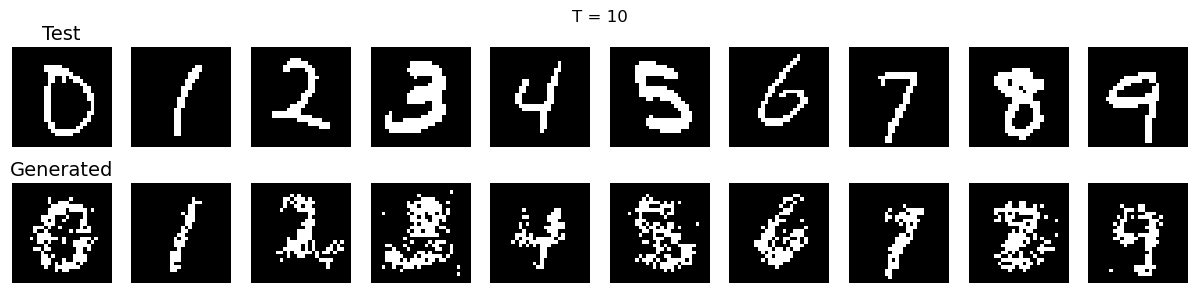

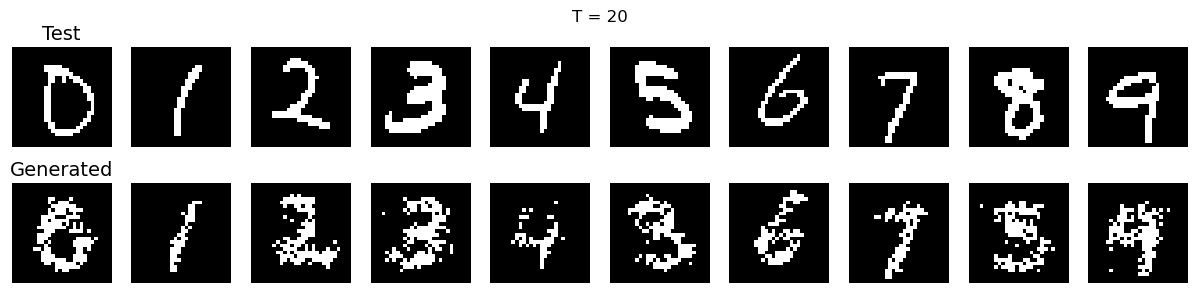

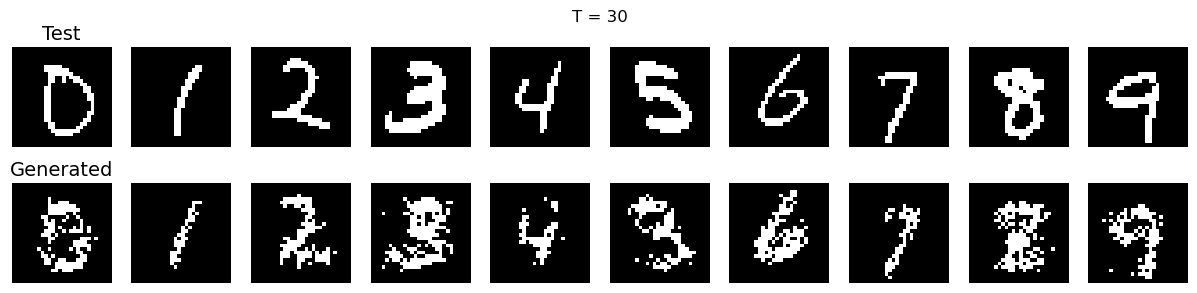

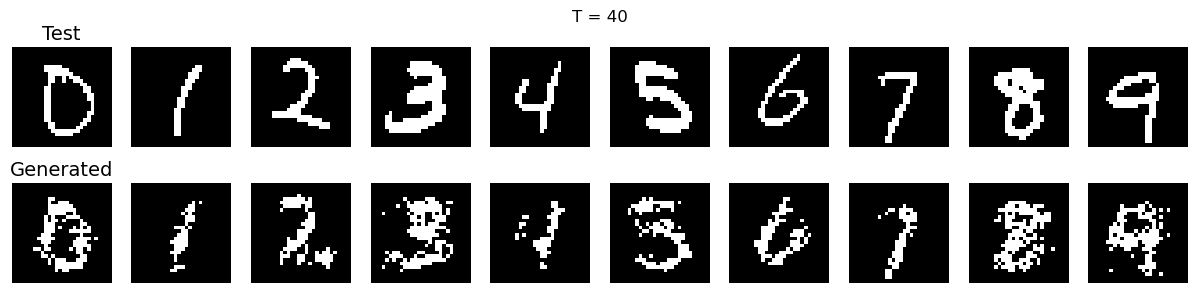

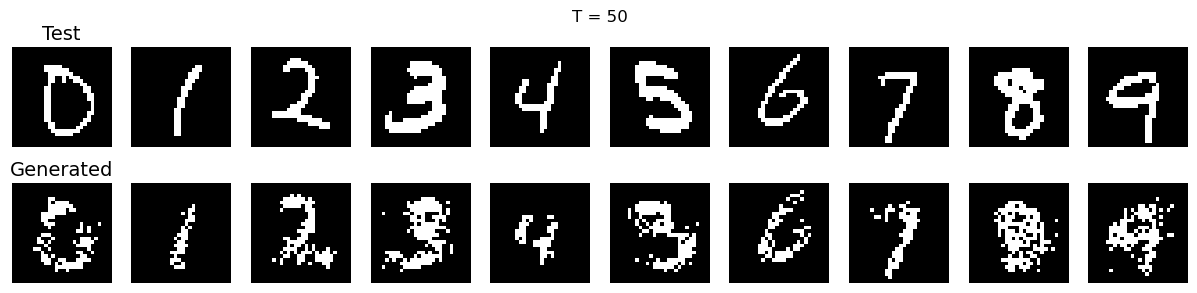

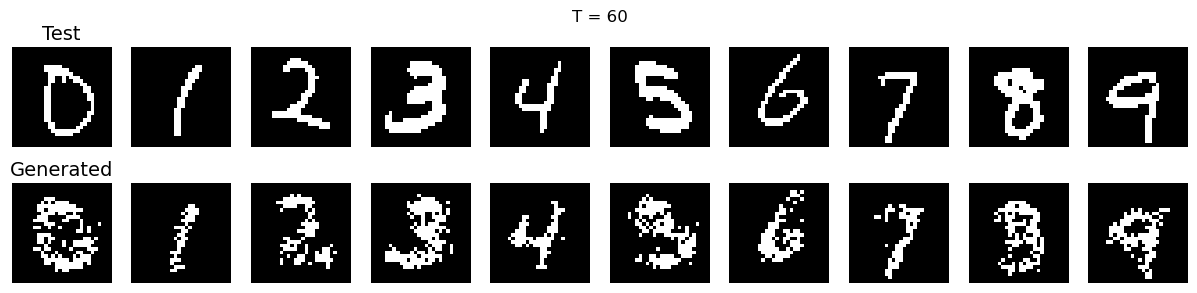

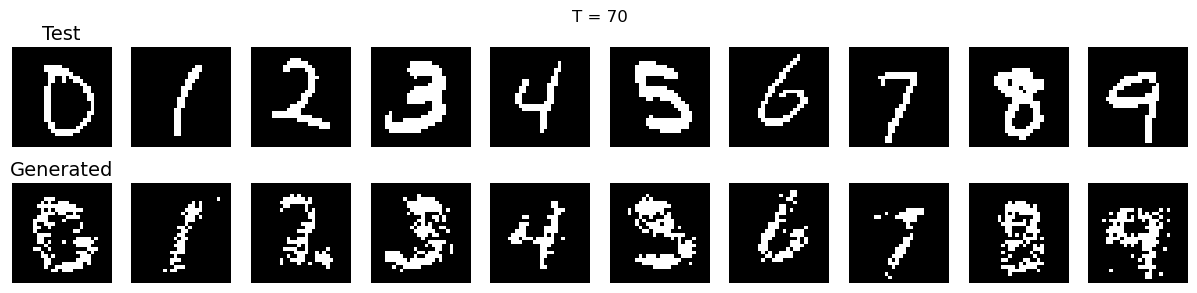

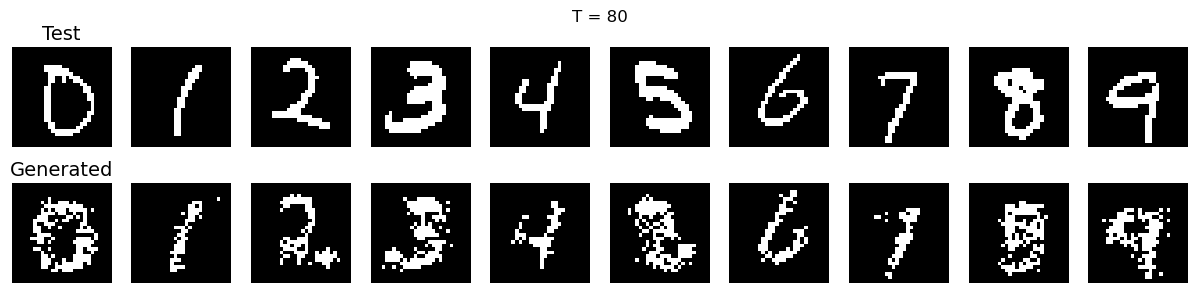

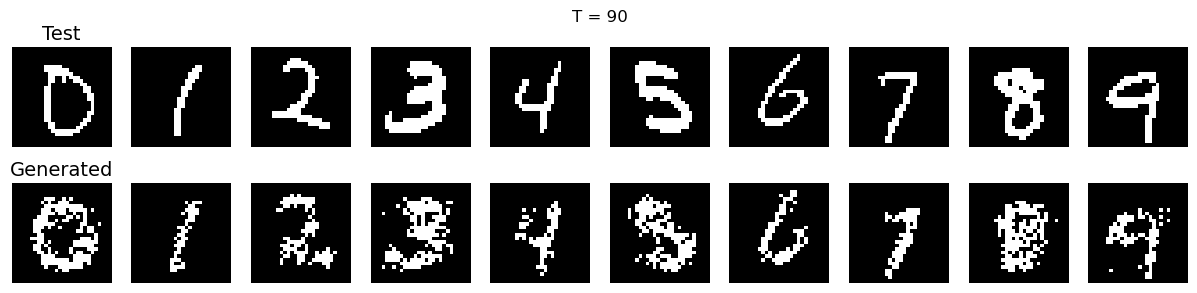

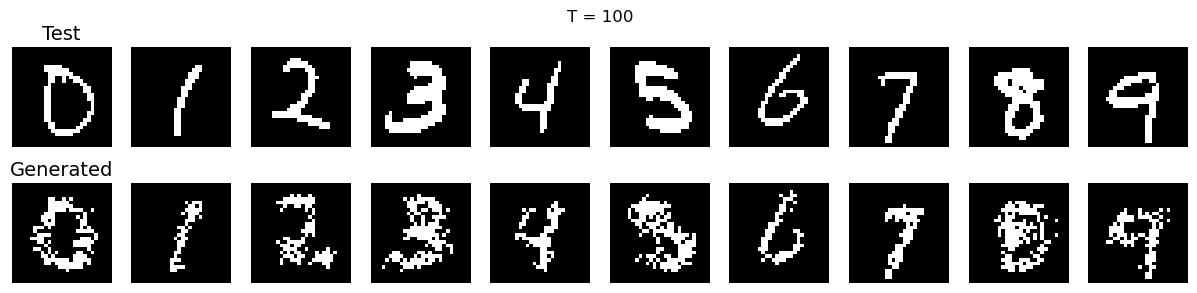

In [20]:
# Generate all plot individually

for i,j in zip(np.arange(10,110,10),tp_rbm['generated']):
    
    fig, ax = plt.subplots(nrows=2, ncols=10, sharey=True, figsize=(12, 3))
    for c in range(10):
        # Original test images
        ax[0, c].imshow(test_images[c].reshape(28, 28), cmap='gray')
        ax[0, c].set_axis_off()
    
        # Reconstructed images
        ax[1, c].imshow(j[c].reshape(28, 28), cmap='gray')
        ax[1, c].set_axis_off()
    
    ax[0, 0].set_title("Test", fontsize=14)
    ax[1, 0].set_title("Generated", fontsize=14)
    
    fig.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.91, wspace=0.2, hspace=0.02)
    plt.suptitle(f"T = {i}")

    plt.savefig(f"figures/generated_images_T{i}.png", dpi=300) 
    
    plt.show()

# Train with T=200

iteration: 1/200 	error: 39.80337990177484
iteration: 2/200 	error: 36.346482532221444
iteration: 3/200 	error: 36.69460422054453
iteration: 4/200 	error: 36.92289887440297
iteration: 5/200 	error: 36.95601910780834
iteration: 6/200 	error: 37.05351287353562
iteration: 7/200 	error: 37.14367584705713
iteration: 8/200 	error: 37.212029700933094
iteration: 9/200 	error: 37.22533390143719
iteration: 10/200 	error: 37.18530038519818
iteration: 11/200 	error: 37.137244526011145
iteration: 12/200 	error: 36.962690413840896
iteration: 13/200 	error: 36.77003238968892
iteration: 14/200 	error: 36.630853647404955
iteration: 15/200 	error: 36.54089426267475
iteration: 16/200 	error: 36.48017413676373
iteration: 17/200 	error: 36.422722059920204
iteration: 18/200 	error: 36.29584119710591
iteration: 19/200 	error: 36.175688813608275
iteration: 20/200 	error: 36.11260380424171
iteration: 21/200 	error: 36.0651619157212
iteration: 22/200 	error: 36.02708114059121
iteration: 23/200 	error: 35.983172

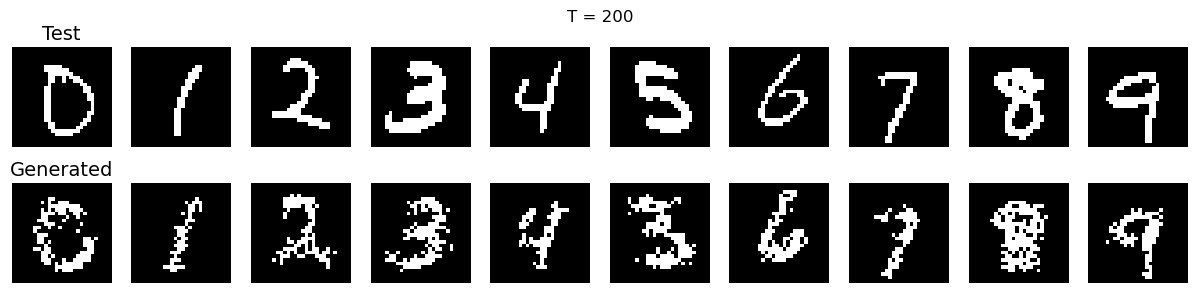

In [22]:
rbm = RBM(Nv=X_train.shape[1], Nh=30, T=200, L=16, gamma=0.1)

# Start timer
start_time = time.time()
rbm.optimizeRBM(X_train)
end_time = time.time()
# End timer

# Calculate and display the runtime
runtime = end_time - start_time
print(f"Training completed in {runtime:.2f} seconds.")

# from the test set get images with labels {0, 1, ..., 9)
test_labels = [np.where(Y_test == str(i))[0][0] for i in range(10)] # labels indices
test_images = X_test[test_labels] # 10 images with the digits
generated = rbm.identify_X(test_images) # RBM reconstruction of the test images


try:
    with open('models/rbm200.pkl', 'wb') as f:
        pickle.dump(rbm, f)
    print("Pickle file saved successfully.")
except Exception as e:
    print(f"Error saving pickle file: {e}")

    
# Plot the input and output images
fig, ax = plt.subplots(nrows=2, ncols=10, sharey=True, figsize=(12, 3))
for c in range(10):
    # Original test images
    ax[0, c].imshow(test_images[c].reshape(28, 28), cmap='gray')  # Reshape to 28x28 for MNIST
    ax[0, c].set_axis_off()

    # Reconstructed images
    ax[1, c].imshow(generated[c].reshape(28, 28), cmap='gray')  # Reshape to 28x28 for MNIST
    ax[1, c].set_axis_off()

# Add titles
ax[0, 0].set_title("Test", fontsize=14)
ax[1, 0].set_title("Generated", fontsize=14)

# Adjust layout
fig.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.91, wspace=0.2, hspace=0.02)
plt.suptitle(f"T = {rbm.T}")

plt.savefig(f"figures/generated_images_T200.png", dpi=300)

# Display the plot
plt.show()

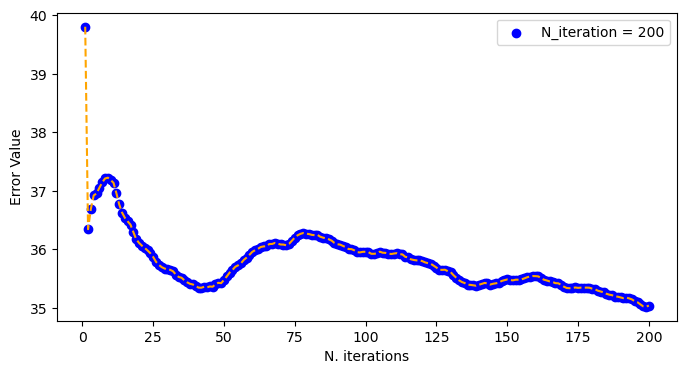

In [23]:
with open('models/rbm200.pkl', 'rb') as f:
    rbm200 = pickle.load(f)

# Original y_values and append new value
y_values = tp_rbm['runtime'].copy()
y_values = y_values + [705.77]

# Define x-values including the new point
x_values = np.array([i for i in np.arange(10,110,10)] + [200]).reshape(-1, 1)  # Reshape for LinearReg

# Perform linear regression
model = LinearRegression()
model.fit(x_values, y_values)

# Predict y-values using the linear regression model
y_pred = model.predict(x_values)

# Plot the scatter plot and regression line
plt.figure(figsize = (8,4))
plt.scatter(np.arange(1,201,1), rbm200.errors, color='blue', label=f"N_iteration = 200")
plt.plot(np.arange(1,201,1), rbm200.errors, linestyle='--', color='orange')
plt.xlabel("N. iterations")
plt.ylabel('Error Value')
plt.legend()

plt.savefig(f"figures/error_T200.png", dpi=300,  bbox_inches='tight') 

plt.show()

# Train with T = 400

iteration: 1/400 	error: 39.80337990177484
iteration: 2/400 	error: 36.346482532221444
iteration: 3/400 	error: 36.69460422054453
iteration: 4/400 	error: 36.92289887440297
iteration: 5/400 	error: 36.95601910780834
iteration: 6/400 	error: 37.05351287353562
iteration: 7/400 	error: 37.14367584705713
iteration: 8/400 	error: 37.212029700933094
iteration: 9/400 	error: 37.22533390143719
iteration: 10/400 	error: 37.18530038519818
iteration: 11/400 	error: 37.137244526011145
iteration: 12/400 	error: 36.962690413840896
iteration: 13/400 	error: 36.77003238968892
iteration: 14/400 	error: 36.630853647404955
iteration: 15/400 	error: 36.54089426267475
iteration: 16/400 	error: 36.48017413676373
iteration: 17/400 	error: 36.422722059920204
iteration: 18/400 	error: 36.29584119710591
iteration: 19/400 	error: 36.175688813608275
iteration: 20/400 	error: 36.11260380424171
iteration: 21/400 	error: 36.0651619157212
iteration: 22/400 	error: 36.02708114059121
iteration: 23/400 	error: 35.983172

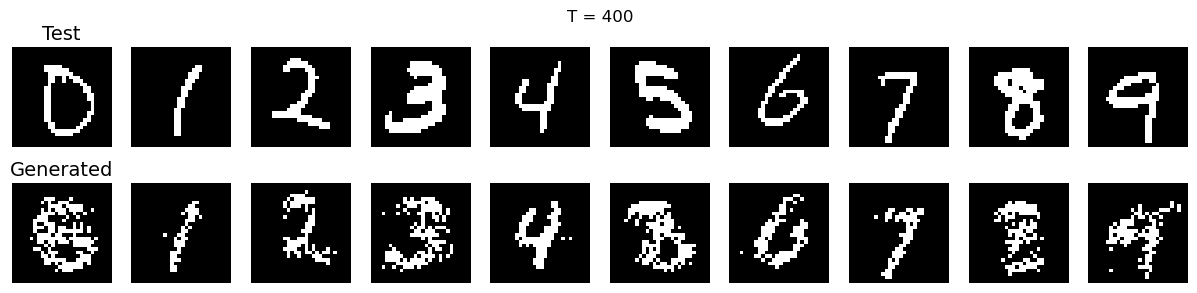

In [25]:
rbm = RBM(Nv=X_train.shape[1], Nh=30, T=400, L=16, gamma=0.1)

# Start timer
start_time = time.time()
rbm.optimizeRBM(X_train)
end_time = time.time()
# End timer

# Calculate and display the runtime
runtime = end_time - start_time
print(f"Training completed in {runtime:.2f} seconds.")

# from the test set get images with labels {0, 1, ..., 9)
test_labels = [np.where(Y_test == str(i))[0][0] for i in range(10)] # labels indices
test_images = X_test[test_labels] # 10 images with the digits
generated = rbm.identify_X(test_images) # RBM reconstruction of the test images


try:
    with open('models/rbm400.pkl', 'wb') as f:
        pickle.dump(rbm, f)
    print("Pickle file saved successfully.")
except Exception as e:
    print(f"Error saving pickle file: {e}")

    
# Plot the input and output images
fig, ax = plt.subplots(nrows=2, ncols=10, sharey=True, figsize=(12, 3))
for c in range(10):
    # Original test images
    ax[0, c].imshow(test_images[c].reshape(28, 28), cmap='gray')  # Reshape to 28x28 for MNIST
    ax[0, c].set_axis_off()

    # Reconstructed images
    ax[1, c].imshow(generated[c].reshape(28, 28), cmap='gray')  # Reshape to 28x28 for MNIST
    ax[1, c].set_axis_off()

# Add titles
ax[0, 0].set_title("Test", fontsize=14)
ax[1, 0].set_title("Generated", fontsize=14)

# Adjust layout
fig.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.91, wspace=0.2, hspace=0.02)
plt.suptitle(f"T = {rbm.T}")

plt.savefig(f"figures/generated_images_T400.png", dpi=300)

# Display the plot
plt.show()

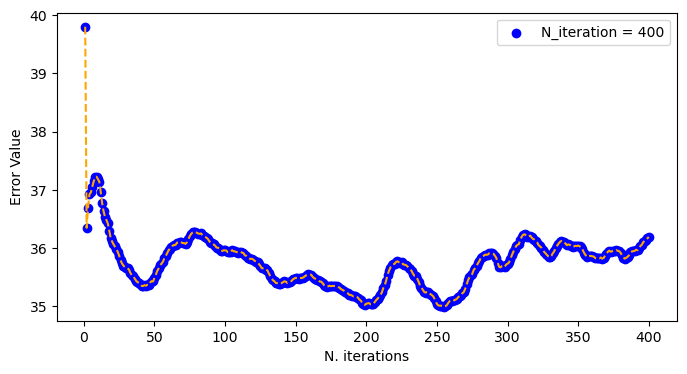

In [26]:
with open('models/rbm400.pkl', 'rb') as f:
    rbm400 = pickle.load(f)

# Original y_values and append new value
y_values = tp_rbm['runtime'].copy()
y_values = y_values + [705.77, 958.39]

# Define x-values including the new point
x_values = np.array([i for i in np.arange(10,110,10)] + [200,400]).reshape(-1, 1)  # Reshape for sklearn

# Perform linear regression
model = LinearRegression()
model.fit(x_values, y_values)

# Predict y-values using the linear regression model
y_pred = model.predict(x_values)

# Plot the scatter plot and regression line
plt.figure(figsize = (8,4))
plt.scatter(np.arange(1,401,1), rbm400.errors, color='blue', label=f"N_iteration = 400")
plt.plot(np.arange(1,401,1), rbm400.errors, linestyle='--', color='orange')
plt.xlabel("N. iterations")
plt.ylabel('Error Value')
plt.legend()

plt.savefig(f"figures/error_T400.png", dpi=300,  bbox_inches='tight') 

plt.show()


## Fine tuning

In [28]:
configurations = []

for n_iter in [20,30,40,50]:
    for n_hidden in [30,40,50,60]:
        for gamma_value in [0.01, 0.1, 0.2]:

            rbm = RBM(Nv=X_train.shape[1], Nh=n_hidden, T=n_iter, gamma = gamma_value, L=16)

            start_time = time.time()

            rbm.optimizeRBM(X_train)
            end_time = time.time()
            # End timer

            # Calculate and display the runtime
            runtime = end_time - start_time

            # # Save the trained model to a file
            model_filename = f'rbm_model_niter_{n_iter}_nhidden_{n_hidden}_gamma_{gamma_value}.pkl'
            joblib.dump(rbm, model_filename)

            # Save the configuration and runtime to the list
            configurations.append({
                'n_iter': n_iter,
                'n_hidden': n_hidden,
                'gamma': gamma_value,
                'runtime': runtime,
                'model_filename': model_filename  # Store the model filename
            })

# Convert the list of configurations into a DataFrame
config_df = pd.DataFrame(configurations)

# Optionally, save the DataFrame to a CSV file
config_df.to_csv("rbm_configurations.csv", index=False)


iteration: 1/20 	error: 56.80435571158043
iteration: 2/20 	error: 42.568178890425116
iteration: 3/20 	error: 39.23523533815522
iteration: 4/20 	error: 37.73057157259836
iteration: 5/20 	error: 36.96669434491164
iteration: 6/20 	error: 36.551045720594594
iteration: 7/20 	error: 36.30832262621131
iteration: 8/20 	error: 36.15760212324639
iteration: 9/20 	error: 36.064980444176314
iteration: 10/20 	error: 36.00710476658071
iteration: 11/20 	error: 35.97532088116232
iteration: 12/20 	error: 35.96125861936444
iteration: 13/20 	error: 35.95766727027902
iteration: 14/20 	error: 35.96857730546465
iteration: 15/20 	error: 35.98697017120484
iteration: 16/20 	error: 36.017402904383744
iteration: 17/20 	error: 36.048090142713846
iteration: 18/20 	error: 36.079676499787375
iteration: 19/20 	error: 36.113688204935436
iteration: 20/20 	error: 36.138705228914155
iteration: 1/20 	error: 39.80337990177484
iteration: 2/20 	error: 36.346482532221444
iteration: 3/20 	error: 36.69460422054453
iteration: 4/2

In [29]:
df_runtime = pd.read_csv("rbm_configurations.csv")

models_dir = "models/"
models = {}

for i in os.listdir(models_dir):
    if i.startswith("rbm_model_niter"):
        models[i[:-4]] = joblib.load(os.path.join(models_dir, i))


In [30]:
models

{'rbm_model_niter_40_nhidden_60_gamma_0.1': <__main__.RBM at 0x387552190>,
 'rbm_model_niter_30_nhidden_40_gamma_0.01': <__main__.RBM at 0x387551f50>,
 'rbm_model_niter_20_nhidden_50_gamma_0.01': <__main__.RBM at 0x398c427d0>,
 'rbm_model_niter_40_nhidden_30_gamma_0.01': <__main__.RBM at 0x387550050>,
 'rbm_model_niter_40_nhidden_60_gamma_0.2': <__main__.RBM at 0x387550890>,
 'rbm_model_niter_30_nhidden_60_gamma_0.2': <__main__.RBM at 0x387553c90>,
 'rbm_model_niter_40_nhidden_40_gamma_0.01': <__main__.RBM at 0x398c41750>,
 'rbm_model_niter_50_nhidden_50_gamma_0.01': <__main__.RBM at 0x318508f10>,
 'rbm_model_niter_30_nhidden_30_gamma_0.01': <__main__.RBM at 0x3875518d0>,
 'rbm_model_niter_30_nhidden_60_gamma_0.1': <__main__.RBM at 0x387552890>,
 'rbm_model_niter_30_nhidden_30_gamma_0.2': <__main__.RBM at 0x387550ad0>,
 'rbm_model_niter_30_nhidden_40_gamma_0.1': <__main__.RBM at 0x387552550>,
 'rbm_model_niter_40_nhidden_50_gamma_0.1': <__main__.RBM at 0x387550bd0>,
 'rbm_model_niter_3

In [31]:
df_metrics_header = ["n_iter", "n_hidden", "gamma", "min_error_idx", "min_error"]

def extract_model_info(model):
    data = []
    data.append(model.T)
    data.append(model.Nh)
    data.append(model.gamma)
    data.append(np.array(model.errors).argmin())
    data.append(np.array(model.errors).min())
    return data


a = extract_model_info(models['rbm_model_niter_20_nhidden_30_gamma_0.01'])
b = extract_model_info(models['rbm_model_niter_20_nhidden_30_gamma_0.2'])

rows = [extract_model_info(models[i]) for i in models.keys()]

df_models = pd.DataFrame(rows, columns=df_metrics_header)

df_metrics = pd.merge(df_models, df_runtime, on=['n_iter', 'n_hidden', 'gamma'], how='left').sort_values('n_iter').reset_index(drop=True)
df_metrics

,n_iter,n_hidden,gamma,min_error_idx,min_error,runtime,model_filename
0,20,30,0.20,1,37.083781,51.909015,rbm_model_niter_20_nhidden_30_gamma_0.2.pkl
1,20,50,0.10,19,26.470658,53.589735,rbm_model_niter_20_nhidden_50_gamma_0.1.pkl
2,20,50,0.01,19,27.961367,73.790606,rbm_model_niter_20_nhidden_50_gamma_0.01.pkl
3,20,60,0.20,15,23.929385,63.481547,rbm_model_niter_20_nhidden_60_gamma_0.2.pkl
4,20,60,0.10,15,24.016352,62.777769,rbm_model_niter_20_nhidden_60_gamma_0.1.pkl
5,20,50,0.20,10,26.853781,57.844200,rbm_model_niter_20_nhidden_50_gamma_0.2.pkl
6,20,40,0.10,19,31.320482,53.186875,rbm_model_niter_20_nhidden_40_gamma_0.1.pkl
7,20,40,0.01,14,31.581172,55.295032,rbm_model_niter_20_nhidden_40_gamma_0.01.pkl
8,20,30,0.01,12,35.957667,52.561581,rbm_model_niter_20_nhidden_30_gamma_0.01.pkl
9,20,60,0.01,19,25.153641,69.170772,rbm_model_niter_20_nhidden_60_gamma_0.01.pkl


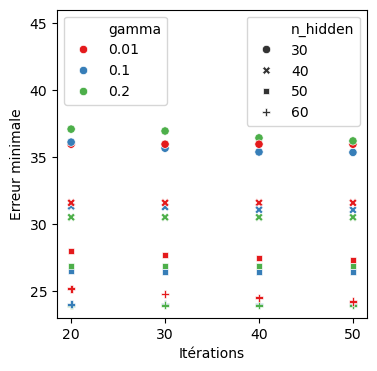

In [32]:
plt.figure(figsize=(4,4))

# Scatter plot
ax = sns.scatterplot(data=df_metrics, x='n_iter', y='min_error', hue='gamma', style='n_hidden', palette='Set1')

plt.xticks([20,30,40,50])
plt.ylim((23,46))
plt.xlabel("Itérations")
plt.ylabel("Erreur minimale")

# Get handles and labels for both hue and style

handles, labels = ax.get_legend_handles_labels()

gamma_handles = handles[:1+len(df_metrics['gamma'].unique())]
gamma_labels = labels[:1+len(df_metrics['gamma'].unique())]

n_hidden_handles = handles[len(df_metrics['n_hidden'].unique()):]
n_hidden_labels = labels[len(df_metrics['n_hidden'].unique()):]

# Create new legend
legend1 = plt.legend(gamma_handles, gamma_labels, loc='upper left', fontsize=10)
legend2 = plt.legend(n_hidden_handles, n_hidden_labels, loc='upper right', fontsize=10)

# Add both legends to the plot
ax.add_artist(legend1)

plt.savefig(f"figures/all_metrics.png", dpi=100, pad_inches=0.1) 

plt.show()


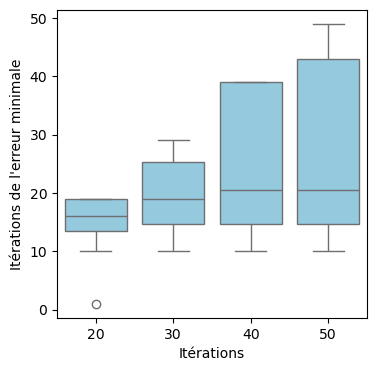

In [33]:
plt.figure(figsize=(4,4))
sns.boxplot(df_metrics, x='n_iter', y='min_error_idx', color='skyblue')
plt.xlabel("Itérations")
plt.ylabel("Itérations de l'erreur minimale")
plt.savefig(f"figures/min_error_indice.png", dpi=100, pad_inches=0.1) 
plt.show()

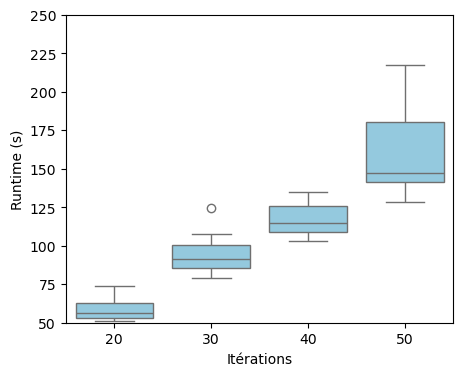

In [34]:
plt.figure(figsize=(5,4))
sns.boxplot(df_metrics, x='n_iter', y='runtime', color='skyblue')
plt.xlabel("Itérations")
plt.ylabel("Runtime (s)")
plt.ylim((50,250)) # remove outlier
plt.savefig(f"figures/runtime_boxplot.png", dpi=100, pad_inches=0.1) 
plt.show()

In [35]:
# Training and test with "best_rbm"

best_rbm = RBM(Nv=X_train.shape[1], Nh=60, T=20, gamma = 0.2, L=16)

start_time = time.time()

best_rbm.optimizeRBM(X_train)
end_time = time.time()
# End timer

# Calculate and display the runtime
runtime = end_time - start_time

# Test
generated_best_rbm = best_rbm.identify_X(test_images)


iteration: 1/20 	error: 29.903157397062362
iteration: 2/20 	error: 26.292733295220884
iteration: 3/20 	error: 25.728967746369992
iteration: 4/20 	error: 25.364512790097514
iteration: 5/20 	error: 25.051088329005417
iteration: 6/20 	error: 24.909920433562117
iteration: 7/20 	error: 24.834210008693
iteration: 8/20 	error: 24.741523153471757
iteration: 9/20 	error: 24.700856514088567
iteration: 10/20 	error: 24.607939564405804
iteration: 11/20 	error: 24.476762001474334
iteration: 12/20 	error: 24.274023951325898
iteration: 13/20 	error: 24.11209308410837
iteration: 14/20 	error: 23.980337689564156
iteration: 15/20 	error: 23.93950827212038
iteration: 16/20 	error: 23.929384884327224
iteration: 17/20 	error: 23.94970242360423
iteration: 18/20 	error: 23.98470950194315
iteration: 19/20 	error: 24.022727689282124
iteration: 20/20 	error: 24.078409762994557


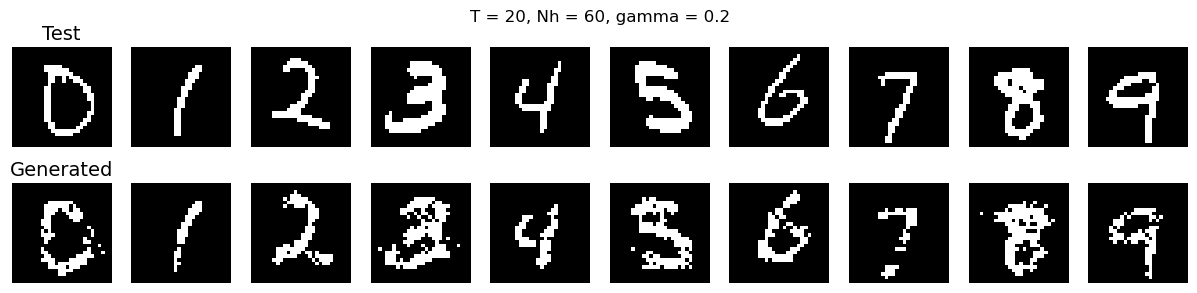

In [36]:
# Plot
fig, ax = plt.subplots(nrows=2, ncols=10, sharey=True, figsize=(12, 3))
for c in range(10):
    # Original test images
    ax[0, c].imshow(test_images[c].reshape(28, 28), cmap='gray')  # Reshape to 28x28 for MNIST
    ax[0, c].set_axis_off()

    # Reconstructed images
    ax[1, c].imshow(generated_best_rbm[c].reshape(28, 28), cmap='gray')  # Reshape to 28x28 for MNIST
    ax[1, c].set_axis_off()

# Add titles
ax[0, 0].set_title("Test", fontsize=14)
ax[1, 0].set_title("Generated", fontsize=14)

# Adjust layout
fig.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.91, wspace=0.2, hspace=0.02)
plt.suptitle(f"T = {best_rbm.T}, Nh = {best_rbm.Nh}, gamma = {best_rbm.gamma}")
plt.savefig(f"figures/best_rbm_hyperparameters.png", dpi=300, bbox_inches='tight')
plt.show()